產出dataset檔案

In [13]:
import os
import shutil
import random
from pathlib import Path

# 資料夾設定
root_dir = Path("/Users/chia-huitsao/Downloads/PHE-SICH-CT-IDS/SubdatasetC_PNG")  # 改成實際路徑
image_root = root_dir / "set"
mask_root = root_dir / "label"
output_base = Path("/Users/chia-huitsao/Documents/PHE-SICH-CT-IDS/Task3/seg_dataset")
(image_train := output_base / "images/train").mkdir(parents=True, exist_ok=True)
(image_val := output_base / "images/val").mkdir(parents=True, exist_ok=True)
(mask_train := output_base / "masks/train").mkdir(parents=True, exist_ok=True)
(mask_val := output_base / "masks/val").mkdir(parents=True, exist_ok=True)

# 收集成對影像與 mask
paired = []
for mask_dir in mask_root.glob("label*/"):
    if not mask_dir.is_dir():
        continue
    label_id = mask_dir.name.replace("label", "")
    image_dir = image_root / f"image{label_id}"
    if not image_dir.exists():
        continue
    for mask_path in mask_dir.glob("*.png"):
        image_path = image_dir / mask_path.name
        if image_path.exists():
            paired.append((image_path, mask_path))

# 分割資料集（80% 訓練 / 20% 驗證）
random.seed(42)
random.shuffle(paired)
split = int(0.8 * len(paired))
train_samples = paired[:split]
val_samples = paired[split:]

# 複製檔案
def copy(pairs, img_out, mask_out):
    for img_path, mask_path in pairs:
        shutil.copy(img_path, img_out / img_path.name)
        shutil.copy(mask_path, mask_out / mask_path.name)

copy(train_samples, image_train, mask_train)
copy(val_samples, image_val, mask_val)

print(f"整理完成，共有影像 {len(paired)} 張，其中訓練 {len(train_samples)}，驗證 {len(val_samples)}")



整理完成，共有影像 3478 張，其中訓練 2782，驗證 696


In [14]:
pip install segmentation-models-pytorch albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 5.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━

In [16]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import os

class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_ids[idx])
        mask_path = os.path.join(self.mask_dir, self.image_ids[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype('float32')  # 二值化，只有 0 or 1

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # HWC → CHW
        image = np.transpose(image, (2, 0, 1)) / 255.0
        mask = np.expand_dims(mask, 0)  # [H, W] → [1, H, W]

        return image.astype('float32'), mask.astype('float32')

In [18]:
from torch.utils.data import DataLoader

# 設定路徑（注意：這裡是 macOS 完整絕對路徑）
seg_path = "/Users/chia-huitsao/Documents/PHE-SICH-CT-IDS/Task3/seg_dataset"

train_dataset = SegDataset(
    image_dir=f"{seg_path}/images/train",
    mask_dir=f"{seg_path}/masks/train",
    transform=None  # 可加 albumentations 增強
)

val_dataset = SegDataset(
    image_dir=f"{seg_path}/images/val",
    mask_dir=f"{seg_path}/masks/val",
    transform=None
)

# 建立 DataLoader（讓你可以 batch 讀入資料）
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [19]:
import segmentation_models_pytorch as smp

# 初始化 U-Net 模型
model = smp.Unet(
    encoder_name="resnet34",        # backbone，可改 efficientnet-b0, mobilenet_v2 等
    encoder_weights="imagenet",     # 預訓練權重加快收斂
    in_channels=3,                  # 輸入影像是 RGB → 3通道
    classes=1,                      # 單類別（二元分割）
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/chia-huitsao/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 11.5MB/s]


Epoch 1/10:   0%|          | 0/1391 [00:00<?, ?it/s]/var/folders/ry/773h_sdx0_3gc6tfwvyp47gm0000gn/T/ipykernel_216/768653586.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
/var/folders/ry/773h_sdx0_3gc6tfwvyp47gm0000gn/T/ipykernel_216/768653586.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(masks).to(device)
Epoch 1/10: 100%|██████████| 1391/1391 [1:09:10<00:00,  2.98s/it]


✅ Epoch 1, Loss: 0.6379


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(b

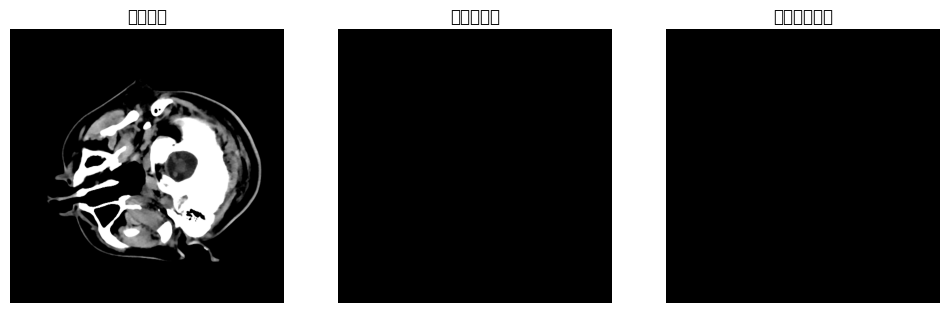

Epoch 2/10: 100%|██████████| 1391/1391 [1:04:25<00:00,  2.78s/it]


✅ Epoch 2, Loss: 0.3832


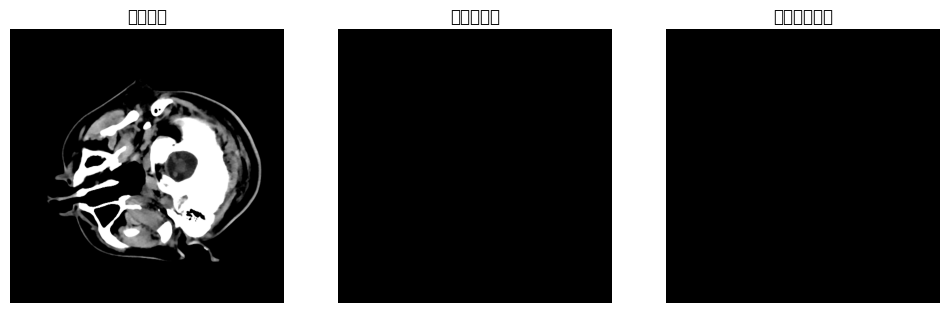

Epoch 3/10: 100%|██████████| 1391/1391 [1:03:52<00:00,  2.76s/it]


✅ Epoch 3, Loss: 0.3066


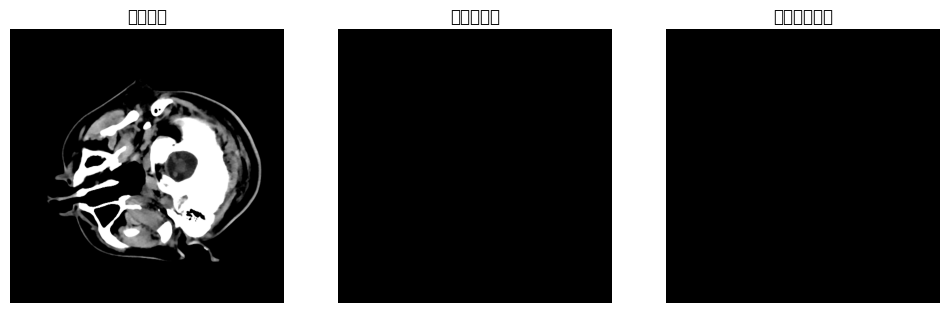

Epoch 4/10: 100%|██████████| 1391/1391 [1:09:56<00:00,  3.02s/it]


✅ Epoch 4, Loss: 0.2452


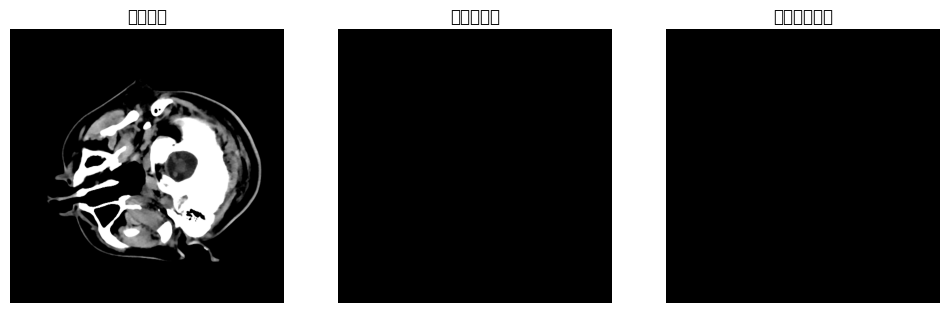

Epoch 5/10: 100%|██████████| 1391/1391 [1:05:25<00:00,  2.82s/it]


✅ Epoch 5, Loss: 0.2185


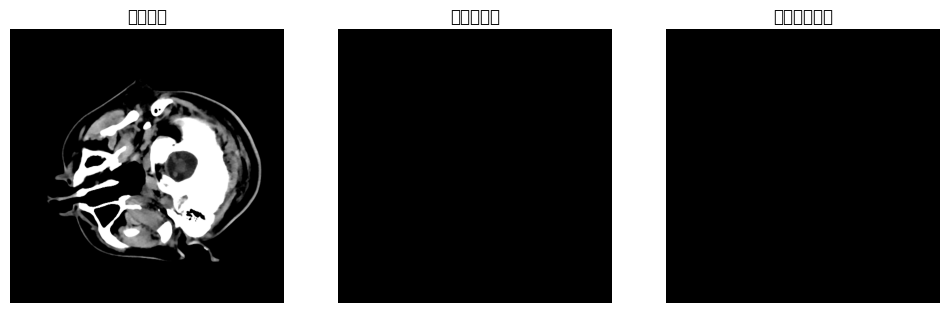

Epoch 6/10: 100%|██████████| 1391/1391 [58:46<00:00,  2.54s/it] 


✅ Epoch 6, Loss: 0.2407


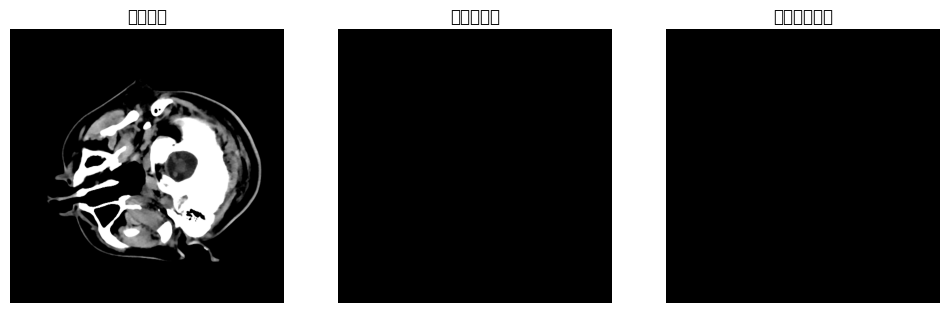

Epoch 7/10: 100%|██████████| 1391/1391 [54:03<00:00,  2.33s/it]


✅ Epoch 7, Loss: 0.2031


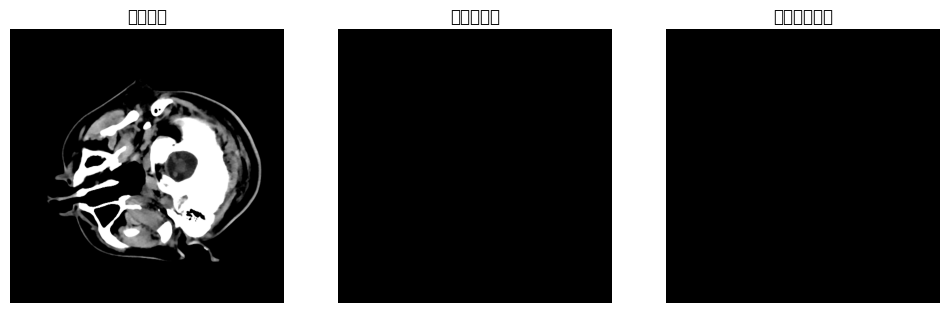

Epoch 8/10: 100%|██████████| 1391/1391 [54:03<00:00,  2.33s/it]


✅ Epoch 8, Loss: 0.1994


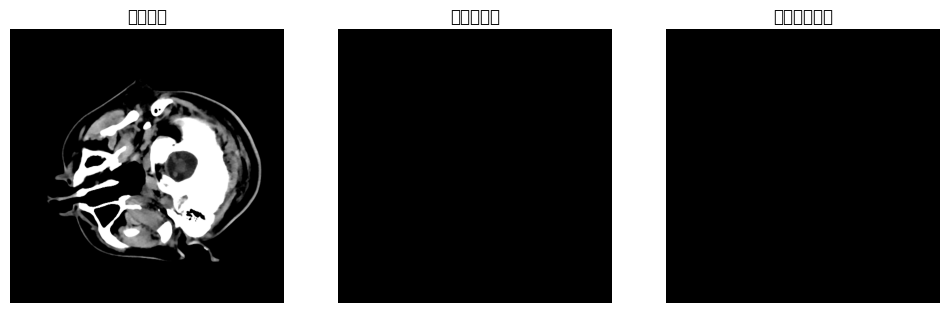

Epoch 9/10: 100%|██████████| 1391/1391 [54:25<00:00,  2.35s/it]


✅ Epoch 9, Loss: 0.1942


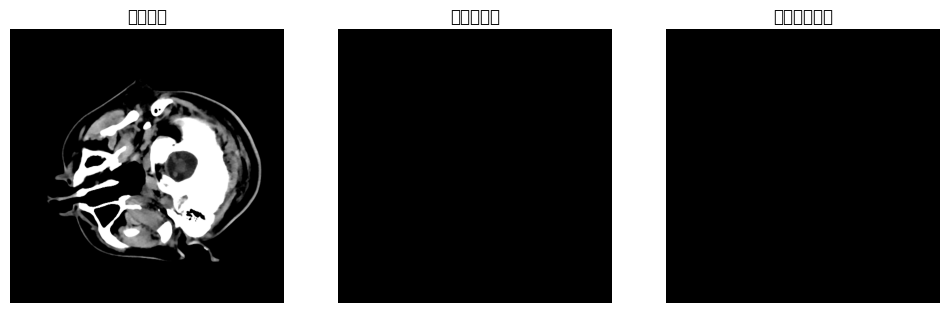

Epoch 10/10: 100%|██████████| 1391/1391 [54:03<00:00,  2.33s/it]


✅ Epoch 10, Loss: 0.1944


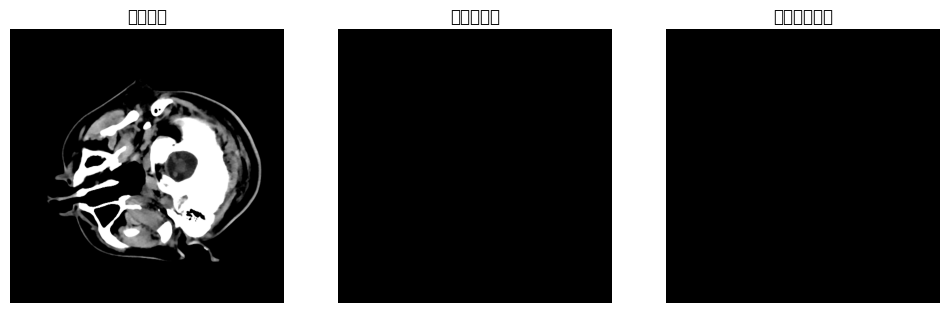

🎉 訓練完成


In [21]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# === 自訂 Dataset 類別 ===
class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_ids[idx])
        mask_path = os.path.join(self.mask_dir, self.image_ids[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype('float32')

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = np.transpose(image, (2, 0, 1)) / 255.0
        mask = np.expand_dims(mask, 0)
        return image.astype('float32'), mask.astype('float32')

# === 可視化函數 ===
def visualize_prediction(model, dataset, index=0, device="cpu"):
    model.eval()
    image, mask = dataset[index]
    image_tensor = torch.tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image_tensor)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float().squeeze().cpu().numpy()

    image_np = (image.transpose(1, 2, 0) * 255).astype(np.uint8)
    mask_np = mask.squeeze()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(image_np); plt.title("原始影像"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(mask_np, cmap="gray"); plt.title("真實出血區"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(pred, cmap="gray"); plt.title("模型預測區域"); plt.axis("off")
    plt.show()

# === 主要程式開始 ===
# 資料路徑（請改成你自己的）
seg_path = "/Users/chia-huitsao/Documents/PHE-SICH-CT-IDS/Task3/seg_dataset"
train_dataset = SegDataset(f"{seg_path}/images/train", f"{seg_path}/masks/train")
val_dataset = SegDataset(f"{seg_path}/images/val", f"{seg_path}/masks/val")
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# 模型設定
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
device = torch.device("cpu")
model = model.to(device)

# Loss 函數設定
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')

def combined_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 訓練迴圈
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = torch.tensor(images).to(device)
        masks = torch.tensor(masks).to(device)

        preds = model(images)
        loss = combined_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # 每個 epoch 顯示一張預測圖
    visualize_prediction(model, val_dataset, index=0, device=device)

print("🎉 訓練完成")

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(b

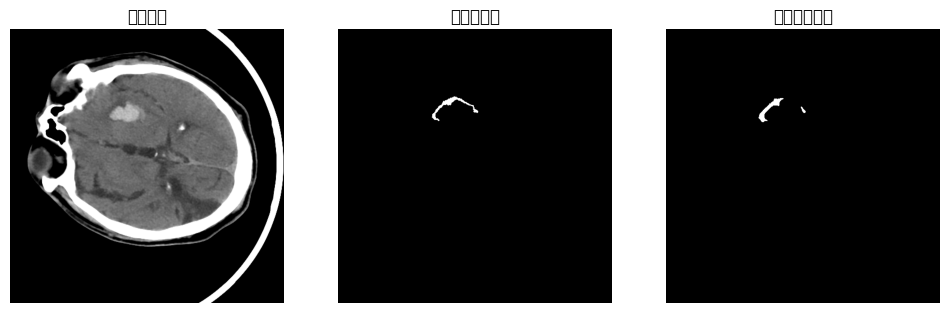

In [37]:
visualize_prediction(model, val_dataset, index=10, device=device)

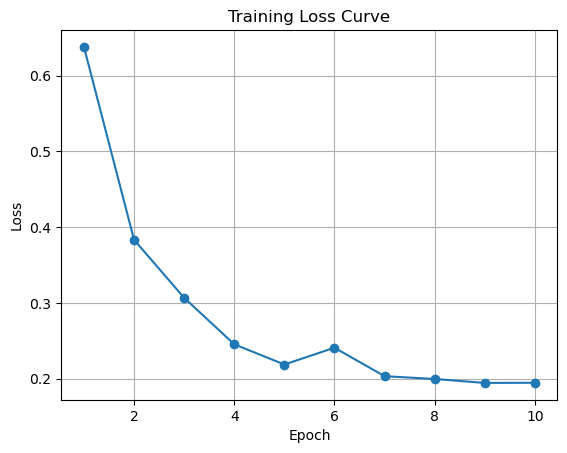

In [41]:
import matplotlib.pyplot as plt
import json
loss_history=[0.6379, 0.3832, 0.3066, 0.2452, 0.2185, 0.2407, 0.2031, 0.1994, 0.1942, 0.1944]
plt.figure()
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [23]:
torch.save(model.state_dict(), "/Users/chia-huitsao/Documents/PHE-SICH-CT-IDS/Task3/unet_task3_final.pt")


In [36]:
import random
import matplotlib.pyplot as plt
import torch
import os

def visualize_random_val_predictions(model, dataset, device="cpu", num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        image, mask = dataset[idx]
        image_tensor = torch.tensor(image).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_tensor)
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float().squeeze().cpu().numpy()

        image_np = (image.transpose(1, 2, 0) * 255).astype(np.uint8)
        mask_np = mask.squeeze()

        # 顯示
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title("原始影像")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("真實出血區")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap="gray")
        plt.title("模型預測區域")
        plt.axis("off")

        plt.suptitle(f"樣本 idx = {idx}")
        plt.show()

In [24]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random

class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_ids[idx])
        mask_path = os.path.join(self.mask_dir, self.image_ids[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype('float32')

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = np.transpose(image, (2, 0, 1)) / 255.0
        mask = np.expand_dims(mask, 0)
        return image.astype('float32'), mask.astype('float32')

In [29]:
import segmentation_models_pytorch as smp
import torch

def calculate_metrics(model, dataloader, device="cpu"):
    model.eval()
    TP = TN = FP = FN = 0
    smooth = 1e-6

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

        TP += ((preds == 1) & (masks == 1)).sum().item()
        TN += ((preds == 0) & (masks == 0)).sum().item()
        FP += ((preds == 1) & (masks == 0)).sum().item()
        FN += ((preds == 0) & (masks == 1)).sum().item()

    dice = (2 * TP) / (2 * TP + FP + FN + smooth)
    iou = TP / (TP + FP + FN + smooth)
    sensitivity = TP / (TP + FN + smooth)
    specificity = TN / (TN + FP + smooth)

    print("\n📊 Segmentation Metrics:")
    print(f"Dice Score:     {dice:.4f}")
    print(f"IoU:            {iou:.4f}")
    print(f"Sensitivity:    {sensitivity:.4f}")
    print(f"Specificity:    {specificity:.4f}")


seg_path = "/Users/chia-huitsao/Documents/PHE-SICH-CT-IDS/Task3/seg_dataset"
val_dataset = SegDataset(f"{seg_path}/images/val", f"{seg_path}/masks/val")
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,   # 自訓練模型不能用 imagenet 權重
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load(
    "/Users/chia-huitsao/Documents/PHE-SICH-CT-IDS/Task3/unet_task3_final.pt",
    map_location="cpu"
))
model.to("cpu")
model.eval()

# 直接評估指標
calculate_metrics(model, val_loader, device="cpu")


📊 Segmentation Metrics:
Dice Score:     0.3936
IoU:            0.2450
Sensitivity:    0.5876
Specificity:    0.9995


In [27]:
"calculate_metrics" in globals()

False